In [67]:
import os
import pydicom
from tqdm import tqdm 
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as F
from torchsummary import summary
import segmentation_models_pytorch as smp
import gc
import random
from ultralytics import YOLO
import wandb

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [3]:
restructured_root = 'data_yolo'
image_dir = os.path.join(restructured_root, 'images')
image_train_dir = os.path.join(image_dir, 'train')
image_val_dir = os.path.join(image_dir, 'val')
image_test_dir = os.path.join(image_dir, 'test')
label_dir = os.path.join(restructured_root, 'labels')
label_train_dir = os.path.join(label_dir, 'train')
label_val_dir = os.path.join(label_dir, 'val')

In [4]:
anno_dir = '/data_vault/hexai02/CarpalTunnel/Annotations'
dicom_dir = '/data_vault/hexai02/CarpalTunnel/Images'

In [117]:
def load_mask(mask_path):
    mask = sitk.ReadImage(mask_path)
    return sitk.GetArrayFromImage(mask)[0][: 450, 200: 1300]

def load_dicom(dicom_path):
    dicom_data = pydicom.dcmread(dicom_path)
    return dicom_data.pixel_array[: 450, 200: 1300, 0]

In [6]:
model = YOLO("runs/detect/train17/weights/best.pt")
model.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [125]:
train_images = []
train_masks = []
val_images = []
val_masks = []

def fill_arr(img_dir, img_bucket, mask_bucket):
    for jpg_name in tqdm(os.listdir(img_dir)): 
        img_filename = jpg_name.split('.')[0] + '.dcm'
        mask_filename = jpg_name.split('.')[0] + '.nii.gz'
        img = load_dicom(os.path.join(dicom_dir, img_filename))
        mask = load_mask(os.path.join(anno_dir, mask_filename))
        img_bucket.append(img)
        mask_bucket.append(mask)
        
        # result = model(img, save=False)
        # box = result[0].boxes
        # # print(box.xyxy.tolist()[0])
        # # break
        # if len(box.xyxy.tolist())== 0:
        #     continue
        # x1, y1, x2, y2 = map(int, box.xyxy.tolist()[0])
        # img_bucket.append(img[y1:y2, x1:x2, 0])
        # mask_bucket.append(mask[y1:y2, x1:x2])

# def fill_arr(img_dir, img_bucket,filetype='.dcm'):
#     for jpg_name in tqdm(os.listdir(img_dir)):
#         filename = jpg_name.split('.')[0] + filetype
#         img = load_dicom(os.path.join(dicom_dir, filename)) if filetype == '.dcm' else load_mask(os.path.join(anno_dir, filename))
#         img_bucket.append(img)

# fill_arr(image_train_dir, train_images)
# fill_arr(image_val_dir, val_images)
# fill_arr(label_train_dir, train_masks, filetype='.nii.gz')
# fill_arr(image_val_dir, val_masks, filetype='.nii.gz')

fill_arr(image_train_dir, train_images, train_masks)
fill_arr(image_val_dir, val_images, val_masks)

100%|███████████████████████████████████████████| 33/33 [00:02<00:00, 12.84it/s]


In [9]:
print(len(train_images), len(val_images))

81 29


In [126]:
def plot_mosaic(img1, img2, img3, img4):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    axes[0, 0].imshow(img1)
    axes[0, 0].axis('off')

    axes[0, 1].imshow(img2)
    axes[0, 1].axis('off')

    axes[1, 0].imshow(img3)
    axes[1, 0].axis('off')

    axes[1, 1].imshow(img4)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

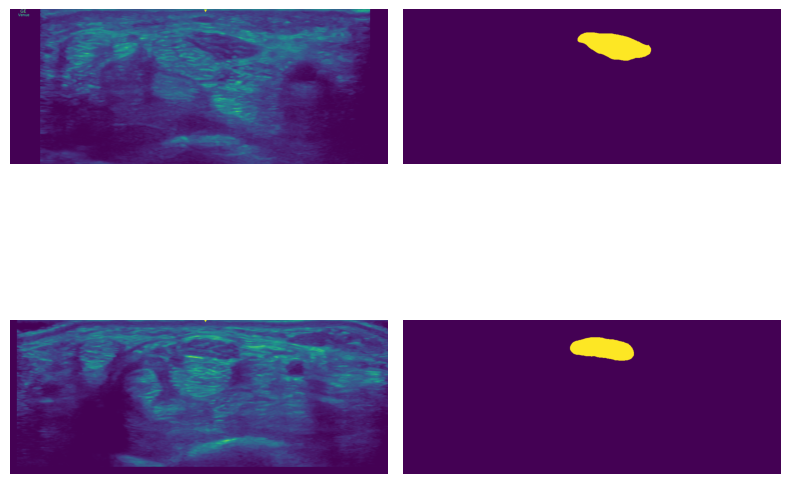

In [127]:
plot_mosaic(train_images[0], train_masks[0], val_images[0], val_masks[0])

In [133]:
class segmentationDataset(torch.utils.data.Dataset):
  """
  Dataset class for segmentation task.
  """
  def __init__(self, image_arr, seg_arr, split='train'):
    self.imgs = image_arr
    self.segs = seg_arr
    self.split = split


  def __len__(self):
    return len(self.imgs)


  def __getitem__(self, idx):
    img = torch.tensor(self.imgs[idx], dtype=torch.float32) / 255.0
    seg = torch.tensor(self.segs[idx])
    img = img.unsqueeze(0)
    seg = seg.unsqueeze(0)


    image_transform = T.Compose([
        T.Normalize(mean=[0.5], std=[0.5]),
        T.Resize((512, 512), interpolation=T.InterpolationMode.BILINEAR),
    ])

    mask_transform = T.Compose([
        T.Resize((512, 512), interpolation=T.InterpolationMode.NEAREST)  # Nearest-neighbor for masks
    ])

    train_transform = T.Compose([

        T.RandomErasing(p=0.5,scale=(0.02,0.1)),
        # T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)
    ])

    img = image_transform(img)
    seg = mask_transform(seg)

    if self.split == 'train':
        if random.random() < 0.5:
            img = F.hflip(img)
            seg = F.hflip(seg.to(torch.float32)).to(torch.uint16)
        angle = random.uniform(-10, 10)
        translate = (random.uniform(-0.1, 0.1) * img.shape[1], 
                     random.uniform(-0.1, 0.1) * img.shape[2])
        scale = random.uniform(0.9, 1.1)
        shear = random.uniform(-10, 10)

        img = F.affine(img, angle, translate, scale, shear, interpolation=T.InterpolationMode.BILINEAR)
        seg = F.affine(seg, angle, translate, scale, shear, interpolation=T.InterpolationMode.NEAREST)
        img = train_transform(img)
        # seg = train_transform(seg)
        
    return img, seg

    # return image_transform(img), mask_transform(seg)

In [134]:
train_masks[0].dtype

dtype('uint16')

In [135]:
train_dataset = segmentationDataset(train_images, train_masks)
val_dataset = segmentationDataset(val_images, val_masks, split='val')
train_dtl     = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = 32,
    shuffle     = True
)

val_dtl = torch.utils.data.DataLoader(
    dataset = val_dataset,
    batch_size = 32,
    shuffle = False
)

In [136]:
for i, data in enumerate(train_dtl):
    imgs_batch, segs_batch = data
    print(imgs_batch.shape)
    print(segs_batch.shape)
    break

torch.Size([32, 1, 512, 512])
torch.Size([32, 1, 512, 512])


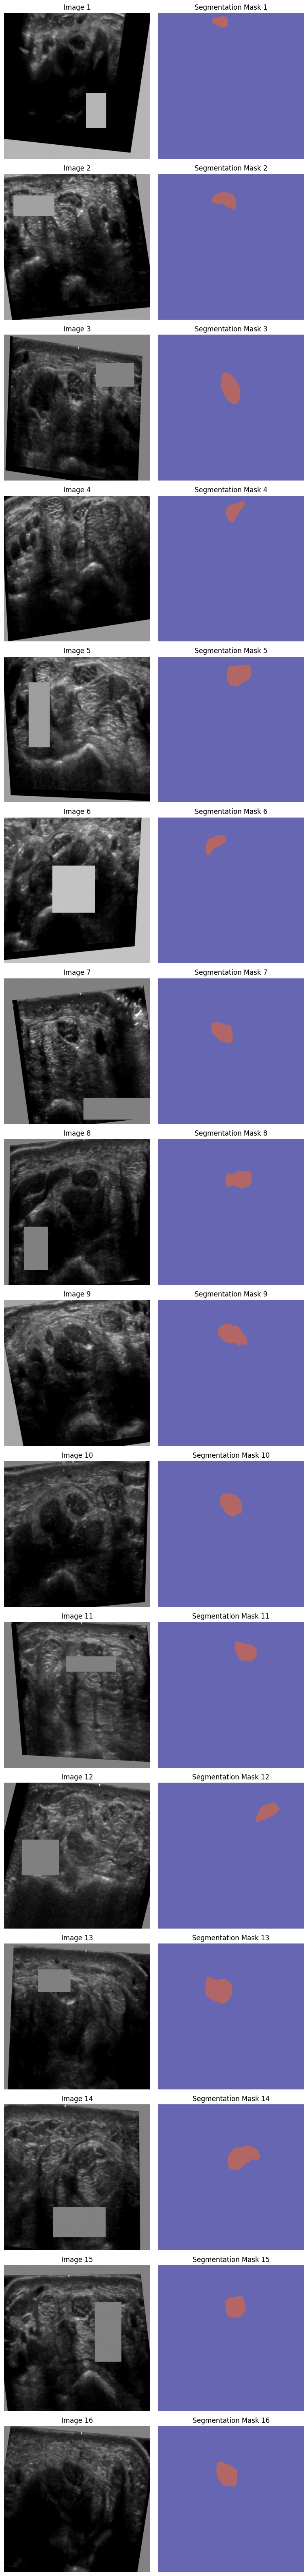

In [137]:


# Function to visualize a batch of images and segmentation masks
def visualize_batch(images, masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))
    
    for i in range(num_samples):
        img = images[i].squeeze().cpu().numpy()  # Convert to numpy and take the first channel
        mask = masks[i].squeeze().cpu().numpy()  # Convert to numpy and take the first channel

        # Normalize image for visualization
        img = (img - img.min()) / (img.max() - img.min())

        axes[i, 0].imshow(img, cmap="gray")
        axes[i, 0].set_title(f"Image {i+1}")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(mask, cmap="jet", alpha=0.6)
        axes[i, 1].set_title(f"Segmentation Mask {i+1}")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

visualize_batch(imgs_batch, segs_batch, num_samples=16)

In [48]:
import gc
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [138]:
config = {
    'epochs': 40,
    'in_channels': 1,
    'dropout': 0.2,
    'decoder_attention_type': 'scse',
    'init_lr': 5e-3,
    'weight_decay': 0.05,
    'T_max': 10,
    'eta_min': 3e-4
}

In [139]:
EPOCHS = config['epochs']
unet_model = smp.Unet(in_channels=1,dropout=config['in_channels'],decoder_attention_type=config['decoder_attention_type']).to(device)

criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

optimizer = torch.optim.AdamW(unet_model.parameters(),
                              lr=config['init_lr'],
                              weight_decay=config['weight_decay'])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max= config['T_max'],
        eta_min=config['eta_min'])

scaler = torch.cuda.amp.GradScaler()

/tmp/ipykernel_1622543/170393104.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [50]:
def save_model(model, optimizer, scheduler, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

In [51]:
unet_root = 'unet_runs'
os.makedirs(unet_root, exist_ok=True)

In [52]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [72]:
def train_loop(dtl, model, criterion, optimzer, scheduler, scaler):
  model.train()
  loss_m = AverageMeter()
  batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Train')
  tps, fps, fns, tns = [], [], [], []
  for i, data in enumerate(dtl):

    imgs_batch, segs_batch = data
    imgs_batch = imgs_batch.to(device)
    segs_batch = segs_batch.to(device)

    with torch.cuda.amp.autocast():
      logits_masks = unet_model(imgs_batch)

      loss = criterion(logits_masks, segs_batch)

      prob_masks = logits_masks.sigmoid()
      pred_masks = (prob_masks > 0.5).float()

    scaler.scale(loss).backward()
    scaler.step(optimzer)
    scaler.update()

    tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), segs_batch.long(), mode="binary")
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    loss_m.update(loss.item())

    batch_bar.set_postfix(
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

    batch_bar.update() # Update tqdm bar

  scheduler.step()
  print("Train loss: {:.04f}\t Learning rate: {:.04f}".format(loss_m.avg, float(optimizer.param_groups[0]['lr'])))
  tps = torch.cat(tps)
  fps = torch.cat(fps)
  fns = torch.cat(fns)
  tns = torch.cat(tns)

  per_image_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro-imagewise")
  dataset_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro")

  print("per image IOU: {:.04f}\nper dataset IOU: {:.04f}".format(per_image_iou, dataset_iou))
  return loss, per_image_iou, dataset_iou
    

In [71]:
def val_loop(dtl, model, criterion):
  model.eval()
  loss_m = AverageMeter()
  batch_bar = tqdm(total=len(dtl), dynamic_ncols=True, leave=False, position=0, desc='Validation')
  tps, fps, fns, tns = [], [], [], []
  for i, data in enumerate(dtl):

    imgs_batch, segs_batch = data
    imgs_batch = imgs_batch.to(device)
    segs_batch = segs_batch.to(device)

    with torch.inference_mode():
      logits_masks = unet_model(imgs_batch)

      loss = criterion(logits_masks, segs_batch)

      prob_masks = logits_masks.sigmoid()
      pred_masks = (prob_masks > 0.5).float()

    tp, fp, fn, tn = smp.metrics.get_stats(pred_masks.long(), segs_batch.long(), mode="binary")
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)
    loss_m.update(loss.item())

    batch_bar.set_postfix(
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

    batch_bar.update() # Update tqdm bar

  print("Val loss: {:.04f}".format(loss_m.avg))
  tps = torch.cat(tps)
  fps = torch.cat(fps)
  fns = torch.cat(fns)
  tns = torch.cat(tns)

  per_image_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro-imagewise")
  dataset_iou = smp.metrics.iou_score(tps, fps, fns, tns, reduction="micro")

  print("per image IOU: {:.04f}\nper dataset IOU: {:.04f}".format(per_image_iou, dataset_iou))

  return loss, per_image_iou, dataset_iou

In [55]:
gc.collect()
torch.cuda.empty_cache()

In [68]:
wandb.login(key="6e6412a1eff673cacdcda973f6e61422daaa9387")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /home/abk171/.netrc
wandb: Currently logged in as: abk171 (abk171-university-of-pittsburgh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [140]:
run = wandb.init(
    name    = 'full size images', ### Wandb creates random run names if you skip this field, we recommend you give useful names
    reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    #id     = "y28t31uz", ### Insert specific run id here if you want to resume a previous run
    #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "unet", ### Project should be created in your wandb account
    config  = config ### Wandb Config for your run
)

train_dataset_iou,▁▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
train_loss,█▆▇▆▅▄▆▄▃▃▂▂▂▃▂▂▂▂▂▃▂▂▂▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂
train_per_image_iou,▁▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
val_dataset_iou,▁▁▁▁▁▁▆▇▇▇▇▇▇▇▇▇▃▇▇▆▄▄▆█▂▇▇▇███████████▇
val_loss,██████▂▂▂▂▁▁▁▂▁▁▅▁▂▂▄▄▂▁▇▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂
val_per_image_iou,▁▁▁▁▁▁▆▇▇▇▇▇▇▇▇▇▃▇▇▆▄▄▆█▂▇▇▇███████████▇
train_dataset_iou,0.84493
train_loss,0.10024
train_per_image_iou,0.84207
val_dataset_iou,0.72857
val_loss,0.15727


In [141]:
best_iou = 0
best_epoch = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1} / {EPOCHS}')
    train_loss, train_per_image_iou, train_dataset_iou = train_loop(train_dtl, unet_model, criterion, optimizer, scheduler, scaler)
    val_loss, val_per_image_iou, val_dataset_iou =val_loop(val_dtl, unet_model, criterion)
    wandb.log({'train_loss': train_loss, 'train_per_image_iou': train_per_image_iou, 'train_dataset_iou': train_dataset_iou,
               'val_loss': val_loss, 'val_per_image_iou': val_per_image_iou, 'val_dataset_iou': val_dataset_iou, 'lr': scheduler.get_last_lr()[0]})
    
    if val_dataset_iou > best_iou:
        best_iou = val_dataset_iou
        best_epoch = epoch

    save_model(unet_model, optimizer, scheduler, epoch, os.path.join(unet_root, f"epoch_{epoch+1}.pth"))

Epoch 1 / 40


/tmp/ipykernel_1622543/3753527618.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
                                                                                

Train loss: 0.9595	 Learning rate: 0.0049
per image IOU: 0.0219
per dataset IOU: 0.0216


Val loss: 0.9673
per image IOU: 0.0190
per dataset IOU: 0.0190
Epoch 2 / 40


Train loss: 0.9465	 Learning rate: 0.0046
per image IOU: 0.0351
per dataset IOU: 0.0345


Val loss: 0.9673
per image IOU: 0.0190
per dataset IOU: 0.0190
Epoch 3 / 40


Train loss: 0.9334	 Learning rate: 0.0040
per image IOU: 0.0506
per dataset IOU: 0.0483


Val loss: 0.9673
per image IOU: 0.0190
per dataset IOU: 0.0190
Epoch 4 / 40


Train loss: 0.9148	 Learning rate: 0.0034
per image IOU: 0.0742
per dataset IOU: 0.0658


Val loss: 0.9673
per image IOU: 0.0190
per dataset IOU: 0.0190
Epoch 5 / 40


Train loss: 0.8897	 Learning rate: 0.0027
per image IOU: 0.1264
per dataset IOU: 0.1036


Val loss: 0.9668
per image IOU: 0.0193
per dataset IOU: 0.0193
Epoch 6 / 40


Train loss: 0.8536	 Learning rate: 0.0019
per image IOU: 0.1544
per dataset IOU: 0.1248


Val loss: 0.9671
per image IOU: 0.0191
per dataset IOU: 0.0191
Epoch 7 / 40


Train loss: 0.8071	 Learning rate: 0.0013
per image IOU: 0.2614
per dataset IOU: 0.2028


Val loss: 0.9625
per image IOU: 0.0211
per dataset IOU: 0.0211
Epoch 8 / 40


Train loss: 0.7407	 Learning rate: 0.0007
per image IOU: 0.3678
per dataset IOU: 0.3175


Val loss: 0.9692
per image IOU: 0.0216
per dataset IOU: 0.0216
Epoch 9 / 40


Train loss: 0.6962	 Learning rate: 0.0004
per image IOU: 0.4348
per dataset IOU: 0.4173


Val loss: 0.9479
per image IOU: 0.0374
per dataset IOU: 0.0353
Epoch 10 / 40


Train loss: 0.6768	 Learning rate: 0.0003
per image IOU: 0.4300
per dataset IOU: 0.4292


Val loss: 0.8601
per image IOU: 0.1513
per dataset IOU: 0.1408
Epoch 11 / 40


Train loss: 0.6251	 Learning rate: 0.0004
per image IOU: 0.5240
per dataset IOU: 0.5225


Val loss: 0.7829
per image IOU: 0.2615
per dataset IOU: 0.2388
Epoch 12 / 40


Train loss: 0.6087	 Learning rate: 0.0007
per image IOU: 0.5469
per dataset IOU: 0.5378


Val loss: 0.7117
per image IOU: 0.3578
per dataset IOU: 0.3330
Epoch 13 / 40


Train loss: 0.5784	 Learning rate: 0.0013
per image IOU: 0.5589
per dataset IOU: 0.5508


Val loss: 0.6792
per image IOU: 0.4939
per dataset IOU: 0.4688
Epoch 14 / 40


Train loss: 0.5428	 Learning rate: 0.0019
per image IOU: 0.5515
per dataset IOU: 0.5521


Val loss: 0.7494
per image IOU: 0.1669
per dataset IOU: 0.1547
Epoch 15 / 40


Train loss: 0.4795	 Learning rate: 0.0027
per image IOU: 0.5525
per dataset IOU: 0.5463


Val loss: 0.5731
per image IOU: 0.3480
per dataset IOU: 0.3731
Epoch 16 / 40


Train loss: 0.4186	 Learning rate: 0.0034
per image IOU: 0.5071
per dataset IOU: 0.5013


Val loss: 0.5641
per image IOU: 0.2416
per dataset IOU: 0.2502
Epoch 17 / 40


Train loss: 0.2981	 Learning rate: 0.0040
per image IOU: 0.6065
per dataset IOU: 0.5958


Val loss: 0.7116
per image IOU: 0.2149
per dataset IOU: 0.1938
Epoch 18 / 40


Train loss: 0.3238	 Learning rate: 0.0046
per image IOU: 0.5287
per dataset IOU: 0.5359


Val loss: 0.9986
per image IOU: 0.0000
per dataset IOU: 0.0000
Epoch 19 / 40


Train loss: 0.3116	 Learning rate: 0.0049
per image IOU: 0.5243
per dataset IOU: 0.5274


Val loss: 0.9994
per image IOU: 0.0000
per dataset IOU: 0.0000
Epoch 20 / 40


Train loss: 0.3093	 Learning rate: 0.0050
per image IOU: 0.5519
per dataset IOU: 0.5434


Val loss: 0.9581
per image IOU: 0.0426
per dataset IOU: 0.0386
Epoch 21 / 40


Train loss: 0.2514	 Learning rate: 0.0049
per image IOU: 0.5980
per dataset IOU: 0.6047


Val loss: 0.9174
per image IOU: 0.0904
per dataset IOU: 0.0913
Epoch 22 / 40


Train loss: 0.2578	 Learning rate: 0.0046
per image IOU: 0.5983
per dataset IOU: 0.5997


Val loss: 0.9284
per image IOU: 0.0487
per dataset IOU: 0.0483
Epoch 23 / 40


Train loss: 0.2284	 Learning rate: 0.0040
per image IOU: 0.6250
per dataset IOU: 0.6206


Val loss: 0.9258
per image IOU: 0.0583
per dataset IOU: 0.0574
Epoch 24 / 40


Train loss: 0.2278	 Learning rate: 0.0034
per image IOU: 0.6464
per dataset IOU: 0.6241


Val loss: 0.8895
per image IOU: 0.1260
per dataset IOU: 0.1208
Epoch 25 / 40


Train loss: 0.1958	 Learning rate: 0.0027
per image IOU: 0.6813
per dataset IOU: 0.6711


Val loss: 0.7110
per image IOU: 0.2259
per dataset IOU: 0.2143
Epoch 26 / 40


Train loss: 0.2045	 Learning rate: 0.0019
per image IOU: 0.6587
per dataset IOU: 0.6579


Val loss: 0.7110
per image IOU: 0.2155
per dataset IOU: 0.2040
Epoch 27 / 40


Train loss: 0.1740	 Learning rate: 0.0013
per image IOU: 0.7059
per dataset IOU: 0.7020


Val loss: 0.6938
per image IOU: 0.2574
per dataset IOU: 0.2443
Epoch 28 / 40


Train loss: 0.1586	 Learning rate: 0.0007
per image IOU: 0.7246
per dataset IOU: 0.7314


Val loss: 0.5434
per image IOU: 0.3805
per dataset IOU: 0.3483
Epoch 29 / 40


Train loss: 0.1483	 Learning rate: 0.0004
per image IOU: 0.7390
per dataset IOU: 0.7380


Val loss: 0.3860
per image IOU: 0.5987
per dataset IOU: 0.5772
Epoch 30 / 40


Train loss: 0.1745	 Learning rate: 0.0003
per image IOU: 0.7103
per dataset IOU: 0.6985


Val loss: 0.2857
per image IOU: 0.7083
per dataset IOU: 0.7084
Epoch 31 / 40


Train loss: 0.1454	 Learning rate: 0.0004
per image IOU: 0.7372
per dataset IOU: 0.7444


Val loss: 0.2751
per image IOU: 0.7458
per dataset IOU: 0.7505
Epoch 32 / 40


Train loss: 0.1692	 Learning rate: 0.0007
per image IOU: 0.7042
per dataset IOU: 0.7077


Val loss: 0.4039
per image IOU: 0.7569
per dataset IOU: 0.7647
Epoch 33 / 40


Train loss: 0.1538	 Learning rate: 0.0013
per image IOU: 0.7245
per dataset IOU: 0.7316


Val loss: 0.5694
per image IOU: 0.7382
per dataset IOU: 0.7423
Epoch 34 / 40


Train loss: 0.1640	 Learning rate: 0.0019
per image IOU: 0.7249
per dataset IOU: 0.7259


Val loss: 0.5760
per image IOU: 0.7227
per dataset IOU: 0.7221
Epoch 35 / 40


Train loss: 0.1501	 Learning rate: 0.0027
per image IOU: 0.7360
per dataset IOU: 0.7363


Val loss: 0.5784
per image IOU: 0.7211
per dataset IOU: 0.7146
Epoch 36 / 40


Train loss: 0.1697	 Learning rate: 0.0034
per image IOU: 0.7228
per dataset IOU: 0.7074


Val loss: 0.5709
per image IOU: 0.7347
per dataset IOU: 0.7375
Epoch 37 / 40


Train loss: 0.1636	 Learning rate: 0.0040
per image IOU: 0.7050
per dataset IOU: 0.7212


Val loss: 0.5715
per image IOU: 0.7271
per dataset IOU: 0.7366
Epoch 38 / 40


Train loss: 0.1702	 Learning rate: 0.0046
per image IOU: 0.7057
per dataset IOU: 0.7103


Val loss: 0.5722
per image IOU: 0.7270
per dataset IOU: 0.7337
Epoch 39 / 40


Train loss: 0.1375	 Learning rate: 0.0049
per image IOU: 0.7427
per dataset IOU: 0.7619


Val loss: 0.7411
per image IOU: 0.3495
per dataset IOU: 0.3420
Epoch 40 / 40


Train loss: 0.1695	 Learning rate: 0.0050
per image IOU: 0.6925
per dataset IOU: 0.7075


Val loss: 0.6548
per image IOU: 0.5414
per dataset IOU: 0.5204


In [79]:
run.finish()

train_dataset_iou,▁▄▅▇▇▇▇▇▇▇▇█▇██▇████████▇███████████████
train_loss,█▆▄▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁
train_per_image_iou,▁▄▅▇▇▇▇▇▇▇▇█▇██▇████████▇███████████████
val_dataset_iou,▁▁▁▁▁▂▄▆▇██████████████▇▇▇██████████████
val_loss,█████▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_per_image_iou,▁▁▁▁▁▂▄▆▇██████████████▇▇▇██████████████
train_dataset_iou,0.87291
train_loss,0.06128
train_per_image_iou,0.87172
val_dataset_iou,0.85447
val_loss,0.07873


In [107]:
print(best_iou, best_epoch)

tensor(0.8390, device='cuda:0') 35
